In [1]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
from torchvision import transforms as T
import torchvision.transforms.functional as F
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from PIL import Image
from tqdm import tqdm
import cv2

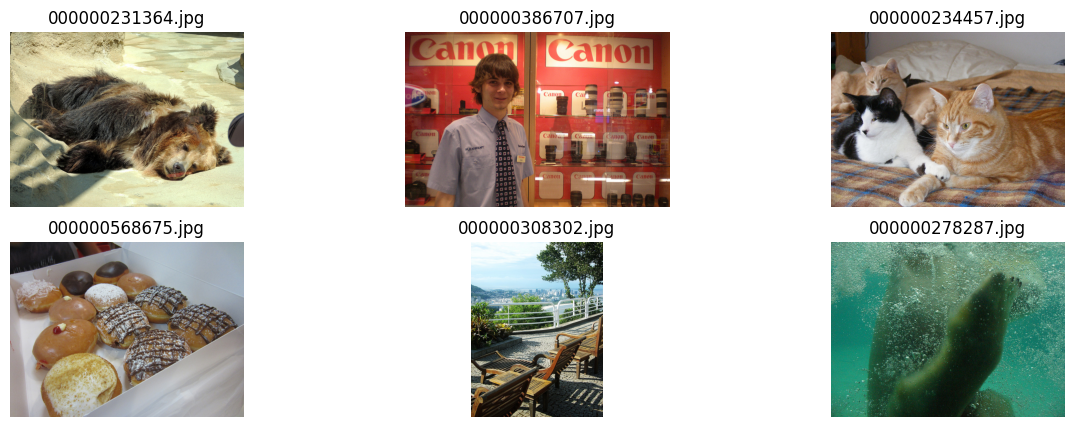

In [2]:
# Read folder
data_root = "/kaggle/input/coco-minitrain-10k/coco_minitrain_10k/"
train_folder = os.path.join(data_root, "images", "train2017") # Updated path
image_files = [i for i in os.listdir(train_folder) if i.endswith(('.jpg', '.jpeg', '.png'))]

# Pick random 6 images
random_images = random.sample(image_files, 6)

plt.figure(figsize=(15,5))

for i, img_name in enumerate(random_images):
    img_path = os.path.join(train_folder, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(img_name)
plt.show()


In [3]:
import os
import torch
from torch.utils.data import Dataset # Import Dataset
import torchvision.transforms.functional as F
from PIL import Image
import random
# from pycocotools.coco import COCO # You can remove this import as it's no longer needed

class CustomYOLODataset(Dataset):
    def __init__(self, img_folder, label_folder, train=False):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.train = train

        # Get list of image files. Assuming image and label files have the same base name.
        self.image_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.image_files.sort() # Ensure consistent order for pairing with labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_folder, img_name)
        # Create the corresponding label file name (e.g., 'image.jpg' -> 'image.txt')
        label_name = img_name.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(self.label_folder, label_name)

        img = Image.open(img_path).convert("RGB")
        image_width, image_height = img.size

        boxes = []
        labels = []
        areas = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    class_id = int(parts[0])
                    x_center_norm, y_center_norm, width_norm, height_norm = parts[1:]

                    # Convert YOLO format (normalized center_x, center_y, width, height)
                    # to Pascal VOC format (x_min, y_min, x_max, y_max) in pixel coordinates
                    x_min = (x_center_norm - width_norm / 2) * image_width
                    y_min = (y_center_norm - height_norm / 2) * image_height
                    x_max = (x_center_norm + width_norm / 2) * image_width
                    y_max = (y_center_norm + height_norm / 2) * image_height

                    # Clamp coordinates to image boundaries to prevent issues
                    x_min = max(0.0, x_min)
                    y_min = max(0.0, y_min)
                    x_max = min(float(image_width), x_max)
                    y_max = min(float(image_height), y_max)

                    # Only add valid bounding boxes (width and height > 0)
                    if x_max > x_min and y_max > y_min:
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(class_id)
                        areas.append((x_max - x_min) * (y_max - y_min)) # Calculate area

        if not boxes: # Handle images with no objects or only invalid boxes
            formatted_target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "image_id": torch.tensor([idx]), # Use idx as a simple image_id
                "area": torch.zeros(0, dtype=torch.float32),
                "iscrowd": torch.zeros(0, dtype=torch.int64)
            }
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64) # Assuming no crowd annotations in YOLO txt

            formatted_target = {
                "boxes": boxes,
                "labels": labels,
                "image_id": torch.tensor([idx]), # Use idx as a simple image_id
                "area": areas,
                "iscrowd": iscrowd
            }

        # Augmentation (Random Horizontal Flip)
        if self.train and random.random() < 0.5:
            img = F.hflip(img)
            if formatted_target["boxes"].numel() > 0: # Only flip boxes if there are any
                bbox = formatted_target["boxes"]
                # New x_min = image_width - old x_max
                # New x_max = image_width - old x_min
                bbox[:, [0, 2]] = image_width - bbox[:, [2, 0]]
                formatted_target["boxes"] = bbox

        # Convert PIL image to PyTorch Tensor
        img = F.to_tensor(img)
        return img, formatted_target

In [4]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms) if transforms else None

# --- 3. Model Definition ---
def get_model(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", pretrain = True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# --- 4. Collate Function for Dataloader ---
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
if __name__ == "__main__":

    data_root = "/kaggle/input/coco-minitrain-10k/coco_minitrain_10k/"

    train_img_folder = os.path.join(data_root, 'images', 'train2017') # Updated path for images
    train_ann_folder = os.path.join(data_root, 'labels', 'train2017') # Updated path for YOLO labels

    val_img_folder = os.path.join(data_root, 'images', 'val2017')   # Assuming val images exist similarly
    val_ann_folder = os.path.join(data_root, 'labels', 'val2017')   # Assuming val labels exist similarly

    # Instantiate the new custom dataset
    dataset = CustomYOLODataset(train_img_folder, train_ann_folder, train=True) # Changed class
    dataset_val = CustomYOLODataset(val_img_folder, val_ann_folder, train=False) # Changed class

    data_loader = DataLoader(
        dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn
    )

    data_loader_val = DataLoader(
        dataset_val, batch_size=2, shuffle= False, num_workers=4, collate_fn=collate_fn
    )

    device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
    
    num_classes = 91 + 1
    model = get_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

    num_epochs = 30
    patience = 5
    best_val_loss = float('inf')
    best_model_path = '/kaggle/working/fasterrcnn_best_model.pt'
    
    print("Bắt đầu quá trình training...")
    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        total_train_loss = 0
        train_loop = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        
        for images, targets in train_loop:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
    
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            current_loss = losses.item()
            total_train_loss += current_loss
            
            # Cập nhật thông tin loss lên thanh tiến trình
            train_loop.set_postfix(loss=f"{current_loss:.4f}")
        
        avg_train_loss = total_train_loss / len(data_loader)
    
        # --- Validation ---
        # Temporarily set to train mode to get the loss dictionary from the model,
        # but ensure no_grad() to prevent gradient computation.
        model.train() 
        total_val_loss = 0
        val_loop = tqdm(data_loader_val, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        
        with torch.no_grad():
            for images, targets in val_loop:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                loss_dict_val = model(images, targets) # This will now return a dict of losses
                losses_val = sum(loss for loss in loss_dict_val.values())
                
                current_val_loss = losses_val.item()
                total_val_loss += current_val_loss
                
                val_loop.set_postfix(val_loss=f"{current_val_loss:.4f}")
                
        avg_val_loss = total_val_loss / len(data_loader_val)
        
        # IMPORTANT: Set the model back to eval mode after the validation pass
        # for proper inference behavior (e.g., for saving or later evaluation).
        model.eval() 

        # In kết quả trung bình của epoch
        print(f"\nEpoch #{epoch+1} Summary: Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}")
    
        # --- Logic Early Stopping và lưu mô hình tốt nhất ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"-> Validation loss cải thiện. Đã lưu mô hình tốt nhất vào '{best_model_path}'\n")
        else:
            epochs_no_improve += 1
            print(f"-> Validation loss không cải thiện. Đã {epochs_no_improve}/{patience} epoch không cải thiện.\n")
    
        if epochs_no_improve >= patience:
            print(f"Early stopping! Dừng training vì validation loss không cải thiện trong {patience} epoch.")
            break
    
    print("\nHoàn tất training!")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 226MB/s] 


Bắt đầu quá trình training...


Epoch 1/30 [Validation]: 100%|██████████| 2500/2500 [06:22<00:00,  6.54it/s, val_loss=0.7799]



Epoch #1 Summary: Avg Train Loss: 0.7388 | Avg Val Loss: 0.6579
-> Validation loss cải thiện. Đã lưu mô hình tốt nhất vào '/kaggle/working/fasterrcnn_best_model.pt'



Epoch 2/30 [Validation]: 100%|██████████| 2500/2500 [06:22<00:00,  6.53it/s, val_loss=0.7577]



Epoch #2 Summary: Avg Train Loss: 0.6084 | Avg Val Loss: 0.6457
-> Validation loss cải thiện. Đã lưu mô hình tốt nhất vào '/kaggle/working/fasterrcnn_best_model.pt'



Epoch 3/30 [Validation]: 100%|██████████| 2500/2500 [06:22<00:00,  6.53it/s, val_loss=0.7114]



Epoch #3 Summary: Avg Train Loss: 0.5999 | Avg Val Loss: 0.6359
-> Validation loss cải thiện. Đã lưu mô hình tốt nhất vào '/kaggle/working/fasterrcnn_best_model.pt'



Epoch 4/30 [Training]:  24%|██▍       | 602/2500 [07:08<20:34,  1.54it/s, loss=0.7285]